## Neural Algorithm of Artistic Style Transfer

This notebook is a Pytorch implementation of style transfer technique proposed by [Gatys et al, 2016](https://arxiv.org/abs/1508.06576).

First let us import the basic libraries

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision.models as models
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
from PIL import Image
import os

In [13]:
device="cpu"
if torch.cuda.is_available():
    device="cuda"
print("Device: {}".format(device))

Device: cpu


#### Task
Given a content picture and a painting, our goal is to impart the style in the painting to our picture while preserving its content. 

This code snippet opens and resizes two images ("iitd.jpg" for content and "starry-night.jpg" for style) using PIL. The images are displayed side by side in a Matplotlib figure for a quick overview.

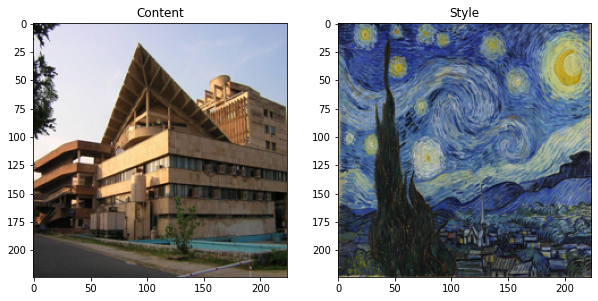

In [14]:
content_img = Image.open("../../Dataset/examples/iitd.jpg").resize((224,224))
style_img = Image.open("../../Dataset/examples/starry-night.jpg").resize((224,224))

fig,ax = plt.subplots(1,2, figsize=(10,5))
ax[0].imshow(content_img)
ax[0].set_title("Content")
ax[1].imshow(style_img)
ax[1].set_title("Style")
plt.show()

This PyTorch module, `EmbeddingGenerator`, utilizes a pretrained VGG19 model to compute content and style activations. The `forward` method processes an input tensor, returning flattened content activations and style activations at specified layers. Customizable content and style layers are set during instantiation.

In [15]:
class EmbeddingGenerator(nn.Module):

    def __init__(self, content_layers=[4], style_layers=[1,2,3,4,5]):
        '''
        Input:
            content_layers: list of numbers indicating convolutional layers to use for content activations
            style_layers: list of numbers indicating convolutional layers to use for style activations
        '''
        super(EmbeddingGenerator, self).__init__()
        
        # load pretrained model and set requires grad to be false for each layer
        pretrained_model = models.vgg19(pretrained=True).features.eval().to(device)
        for layer in pretrained_model:
            layer.requires_grad = False
         
        # extract layers uptil the last of content and style layers
        self.pretrained_layers = []
        self.content_layers = []
        self.style_layers = []
        required_layers = max(max(content_layers), max(style_layers))
        conv_counter = 0
        for i,layer in enumerate(pretrained_model):
            if isinstance(layer,nn.Conv2d):
                conv_counter+=1
                if conv_counter>required_layers:
                    break
                if conv_counter in content_layers:
                    self.content_layers.append(i)
                if conv_counter in style_layers:
                    self.style_layers.append(i)
            
            self.pretrained_layers.append(layer)
        
        self.content_layers = set(self.content_layers)
        self.style_layers = set(self.style_layers)
        
        
    def forward(self, x):
        '''
        Input:
            x - Tensor of shape (1 x 3 x H X W)
        Returns:
            content_activations: list of flattened activations at content layers
            style_activations: list of activations at style layers with shape (n_C X (H*W))
        '''
        content_activations = []
        style_activations = []
        
        for i,layer in enumerate(self.pretrained_layers):
            x = layer(x)
            if i in self.content_layers:
                content_activations.append(x.flatten())
            
            if i in self.style_layers:
                style_activations.append(x.view(x.shape[1],-1))
        
        return content_activations, style_activations

This line instantiates an object embed of the EmbeddingGenerator class

In [16]:
embed = EmbeddingGenerator()

C:\Users\Naina\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Naina\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


This code defines a StyleGenerator class for generating a stylized image by combining content and style images. It includes methods for computing content and style losses, as well as a function to generate the stylized image using LBFGS optimization. The intermediate results are saved in an output directory.

In [17]:
class StyleGenerator:
    '''
    Trainer class that generates output image
    '''
    def __init__(self, embedding_gen):
        '''
        Input:
            embedding_gen: object of EmbeddingGenerator class
        '''
        self.model = embedding_gen
        
        # for normalizing input content and style images
        self.preprocess = transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                    ])
        
        # for denormalizing output image
        self.postprocess = transforms.Compose([ transforms.Normalize(mean = [ 0., 0., 0. ],
                                                     std = [ 1/0.229, 1/0.224, 1/0.225 ]),
                                                transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ],
                                                     std = [ 1., 1., 1. ]),
                                               ])
        
    def gram_matrix(self,x):
        '''
        Compute Gram matrix for given 2D matrix
        '''
        return torch.matmul(x,x.transpose(0,1))/x.numel()

    def compute_content_loss(self,content_activations,inp_content_activations):
        '''
        Inputs:
            content_activations: content layer activations for content image
            inp_content_activations: content layer activations for generated image
        Returns:
            content_loss
        '''
        content_loss = 0.0
        for cont_activ, inp_cont_activ in zip(content_activations, inp_content_activations):
            diff = cont_activ-inp_cont_activ
            content_loss += torch.sum(torch.square(diff))/diff.numel()
        
        return content_loss
    
    def compute_style_loss(self, style_activations, inp_style_activations):
        '''
        Inputs:
            style_activations: style layer activations for style image
            inp_style_activations: style layer activations for generated image
        Returns:
            style_loss
        '''
        style_loss = 0.0
        for style_activ, inp_style_activ in zip(style_activations, inp_style_activations):
            diff = style_activ-inp_style_activ
            style_loss += torch.sum(torch.square(diff))
        
        return style_loss
    
    def generate_stylized_image(self, content_path, style_path, output_dir="images/",
                                content_wt=1.0, style_wt=1000.0, learning_rate=1.0, num_steps=400, image_size=(224,224)):
        '''
        Inputs:
            content_path: path to content image
            style_path: path to style image
            output_dir: output directory for intermediate generated images
            
            content_wt: factor controlling contribution of content loss to total loss
            style_wt: factor controlling contribution of style loss to total loss
            
            learning_rate: learning rate of optimizer
            num_steps: number of steps to be taken by optimizer
            
            image_size: tuple indicating size of input and output images to be used, default is input size expected by VGG19
        '''
        
        # create output directory
        if not os.path.exists(output_dir):
            os.mkdir(output_dir)
        
        # load content and style images and compute relevant activations
        content_img = Image.open(content_path).resize(image_size)
        style_img = Image.open(style_path).resize(image_size)
        
        content = self.preprocess(content_img).unsqueeze(0).to(device)
        style = self.preprocess(style_img).unsqueeze(0).to(device)
        
        content_activations = [x.detach() for x in self.model(content)[0]]   
        style_activations = [self.gram_matrix(x.detach()) for x in self.model(style)[1]]

        # initialize output image with content image + noise, results in faster convergence
        gaussian_noise = torch.clamp(torch.randn(1,3,image_size[0], image_size[1]),-1,1)*0.5
        gen_image = content*0.5 + gaussian_noise.to(device)*0.5
        gen_image = nn.Parameter(gen_image)
        
        # initialize optimizer with gen_image as parameters over which optimization is carried out
        optimizer = torch.optim.LBFGS([gen_image.requires_grad_()], lr=learning_rate)
        
        # initialize as list to allow pass by reference in closure function
    
        runs=[0]
        while runs[0]<num_steps:
            def closure():
                '''
                closure function required by LBFGS optimizer
                '''
                optimizer.zero_grad()
                
                inp_content, inp_style = self.model(gen_image)
                inp_style = [self.gram_matrix(x) for x in inp_style]

                content_loss = self.compute_content_loss(content_activations, inp_content)
                style_loss = self.compute_style_loss(style_activations, inp_style)
                loss = content_wt*content_loss + style_wt*style_loss
                runs[0]+=1
                if runs[0]%40==0:
                    print("Num Steps: {} \tContent Loss: {} \tStyle Loss: {} \tTotal Loss:{}".format(runs[0], 
                                round(content_loss.item(),3), round(style_loss.item(),3), round(loss.item(),3)))
                    # save intermediate outputs
                    plt.imsave(os.path.join(output_dir,"epoch_"+str(runs[0])+".jpg"), 
                               torch.clamp(self.postprocess(gen_image[0].cpu().detach()).permute(1,2,0),0,1).numpy())

                loss.backward()
                return loss
            optimizer.step(closure)
                 
        
        # save final image 
        fig,ax = plt.subplots(1,3, figsize=(15,5),facecolor='w')
        ax[0].imshow(content_img)
        ax[0].set_title("Content")
        ax[1].imshow(style_img)
        ax[1].set_title("Style")
        ax[2].imshow(torch.clamp(self.postprocess(gen_image[0].cpu().detach()).permute(1,2,0),0,1).numpy())
        ax[2].set_title("Generated")
        fig.savefig(os.path.join(output_dir,"final.jpg"))


In [18]:
styler = StyleGenerator(embed)

Now we generate an output image using the content image and style image

Num Steps: 40 	Content Loss: 5.687 	Style Loss: 0.117 	Total Loss:17.413
Num Steps: 80 	Content Loss: 5.244 	Style Loss: 0.024 	Total Loss:7.606
Num Steps: 120 	Content Loss: 4.553 	Style Loss: 0.012 	Total Loss:5.765
Num Steps: 160 	Content Loss: 4.116 	Style Loss: 0.01 	Total Loss:5.104
Num Steps: 200 	Content Loss: 3.903 	Style Loss: 0.008 	Total Loss:4.735
Num Steps: 240 	Content Loss: 3.751 	Style Loss: 0.007 	Total Loss:4.498
Num Steps: 280 	Content Loss: 3.648 	Style Loss: 0.007 	Total Loss:4.338
Num Steps: 320 	Content Loss: 3.57 	Style Loss: 0.007 	Total Loss:4.223
Num Steps: 360 	Content Loss: 3.509 	Style Loss: 0.006 	Total Loss:4.133
Num Steps: 400 	Content Loss: 3.465 	Style Loss: 0.006 	Total Loss:4.065


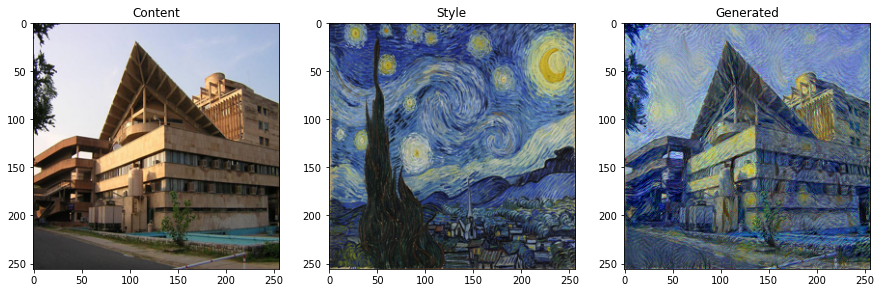

In [26]:
styler.generate_stylized_image(content_path="../../Dataset/examples/iitd.jpg",style_path="../../Dataset/examples/starry-night.jpg", output_dir="../../Dataset/examples/iitd X starry_night/", 
                         content_wt=1.0, style_wt=100.0, image_size=(256,256))

Num Steps: 40 	Content Loss: 3.665 	Style Loss: 0.035 	Total Loss:7.144
Num Steps: 80 	Content Loss: 3.011 	Style Loss: 0.016 	Total Loss:4.602
Num Steps: 120 	Content Loss: 2.683 	Style Loss: 0.01 	Total Loss:3.717
Num Steps: 160 	Content Loss: 2.511 	Style Loss: 0.008 	Total Loss:3.338
Num Steps: 200 	Content Loss: 2.416 	Style Loss: 0.007 	Total Loss:3.131
Num Steps: 240 	Content Loss: 2.358 	Style Loss: 0.007 	Total Loss:3.009
Num Steps: 280 	Content Loss: 2.316 	Style Loss: 0.006 	Total Loss:2.922
Num Steps: 320 	Content Loss: 2.287 	Style Loss: 0.006 	Total Loss:2.855
Num Steps: 360 	Content Loss: 2.265 	Style Loss: 0.005 	Total Loss:2.806
Num Steps: 400 	Content Loss: 2.247 	Style Loss: 0.005 	Total Loss:2.767


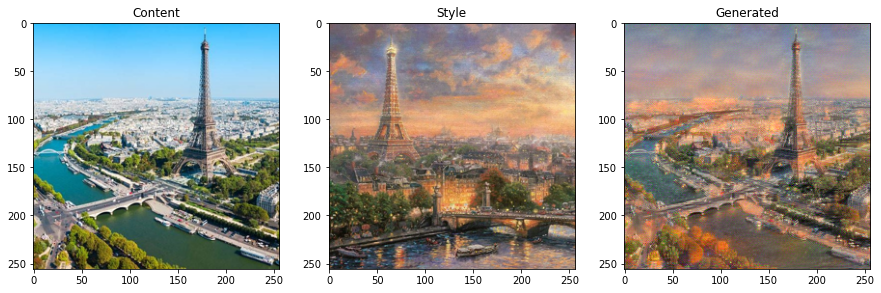

In [20]:
styler.generate_stylized_image(content_path="../../Dataset/examples/paris.jpg",style_path="../../Dataset/examples/paris_painting.jpg", output_dir="../../Dataset/examples/paris",
                         content_wt=1.0, style_wt=100.0, image_size=(256,256))

Num Steps: 40 	Content Loss: 5.949 	Style Loss: 0.242 	Total Loss:30.123
Num Steps: 80 	Content Loss: 6.019 	Style Loss: 0.073 	Total Loss:13.289
Num Steps: 120 	Content Loss: 5.821 	Style Loss: 0.037 	Total Loss:9.519
Num Steps: 160 	Content Loss: 5.574 	Style Loss: 0.025 	Total Loss:8.058
Num Steps: 200 	Content Loss: 5.339 	Style Loss: 0.019 	Total Loss:7.239
Num Steps: 240 	Content Loss: 5.158 	Style Loss: 0.016 	Total Loss:6.76
Num Steps: 280 	Content Loss: 5.002 	Style Loss: 0.014 	Total Loss:6.418
Num Steps: 320 	Content Loss: 4.877 	Style Loss: 0.013 	Total Loss:6.165
Num Steps: 360 	Content Loss: 4.776 	Style Loss: 0.012 	Total Loss:5.973
Num Steps: 400 	Content Loss: 4.693 	Style Loss: 0.011 	Total Loss:5.823


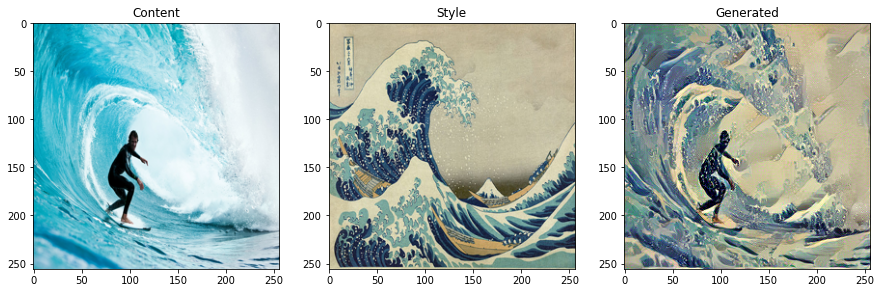

In [21]:
styler.generate_stylized_image(content_path="../../Dataset/examples/surfer.jpg",style_path="../../Dataset/examples/waves.jpg", output_dir="../../Dataset/examples/surfer X waves/",
                         content_wt=1.0, style_wt=100.0, image_size=(256,256))

Num Steps: 40 	Content Loss: 3.35 	Style Loss: 0.177 	Total Loss:21.03
Num Steps: 80 	Content Loss: 3.169 	Style Loss: 0.054 	Total Loss:8.613
Num Steps: 120 	Content Loss: 2.892 	Style Loss: 0.031 	Total Loss:5.96
Num Steps: 160 	Content Loss: 2.665 	Style Loss: 0.022 	Total Loss:4.857
Num Steps: 200 	Content Loss: 2.496 	Style Loss: 0.017 	Total Loss:4.151
Num Steps: 240 	Content Loss: 2.367 	Style Loss: 0.013 	Total Loss:3.641
Num Steps: 280 	Content Loss: 2.249 	Style Loss: 0.01 	Total Loss:3.29
Num Steps: 320 	Content Loss: 2.152 	Style Loss: 0.009 	Total Loss:3.046
Num Steps: 360 	Content Loss: 2.073 	Style Loss: 0.008 	Total Loss:2.87
Num Steps: 400 	Content Loss: 2.011 	Style Loss: 0.007 	Total Loss:2.737


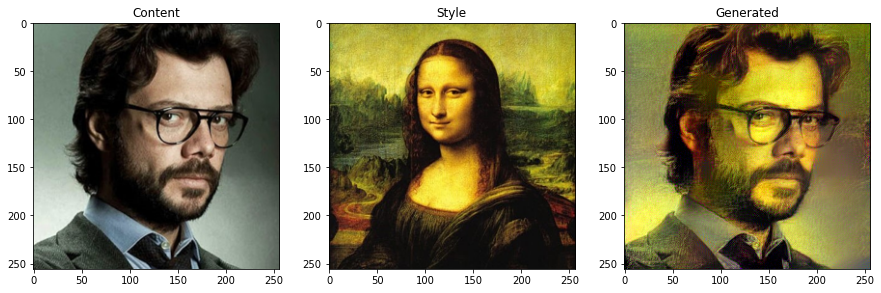

In [22]:
styler.generate_stylized_image(content_path="../../Dataset/examples/professor.jpg",style_path="../../Dataset/examples/monalisa.jpg", output_dir="../../Dataset/examples/professor",
                         content_wt=1.0, style_wt=100.0, image_size=(256,256))

Num Steps: 40 	Content Loss: 4.797 	Style Loss: 0.571 	Total Loss:61.918
Num Steps: 80 	Content Loss: 5.05 	Style Loss: 0.133 	Total Loss:18.369
Num Steps: 120 	Content Loss: 4.717 	Style Loss: 0.045 	Total Loss:9.233
Num Steps: 160 	Content Loss: 4.364 	Style Loss: 0.027 	Total Loss:7.101
Num Steps: 200 	Content Loss: 4.139 	Style Loss: 0.021 	Total Loss:6.211
Num Steps: 240 	Content Loss: 3.983 	Style Loss: 0.017 	Total Loss:5.685
Num Steps: 280 	Content Loss: 3.886 	Style Loss: 0.015 	Total Loss:5.348
Num Steps: 320 	Content Loss: 3.815 	Style Loss: 0.013 	Total Loss:5.101
Num Steps: 360 	Content Loss: 3.759 	Style Loss: 0.012 	Total Loss:4.933
Num Steps: 400 	Content Loss: 3.715 	Style Loss: 0.011 	Total Loss:4.803


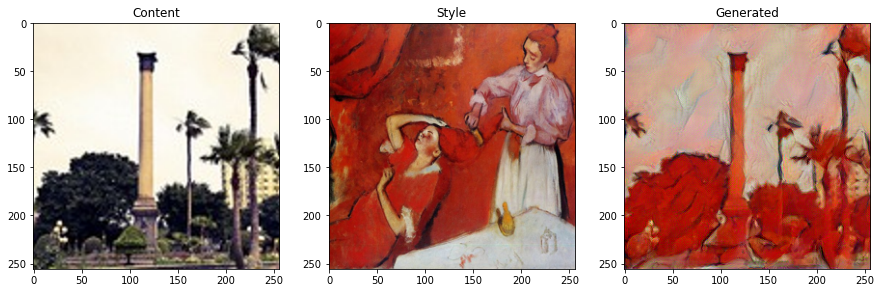

In [23]:
styler.generate_stylized_image(content_path="data/content/Train/4347440092_dfe623f7da_m.jpg",style_path="data/style/artist/Edgar_Degas_117.jpg", output_dir="data/content/Train/4347440092_dfe623f7da_m",
                         content_wt=1.0, style_wt=100.0, image_size=(256,256))

Num Steps: 40 	Content Loss: 4.286 	Style Loss: 0.188 	Total Loss:23.111
Num Steps: 80 	Content Loss: 4.459 	Style Loss: 0.114 	Total Loss:15.904
Num Steps: 120 	Content Loss: 4.464 	Style Loss: 0.08 	Total Loss:12.492
Num Steps: 160 	Content Loss: 4.406 	Style Loss: 0.061 	Total Loss:10.458
Num Steps: 200 	Content Loss: 4.291 	Style Loss: 0.049 	Total Loss:9.184
Num Steps: 240 	Content Loss: 4.202 	Style Loss: 0.042 	Total Loss:8.367
Num Steps: 280 	Content Loss: 4.114 	Style Loss: 0.036 	Total Loss:7.714
Num Steps: 320 	Content Loss: 4.044 	Style Loss: 0.03 	Total Loss:7.034
Num Steps: 360 	Content Loss: 3.973 	Style Loss: 0.024 	Total Loss:6.362
Num Steps: 400 	Content Loss: 3.881 	Style Loss: 0.019 	Total Loss:5.778


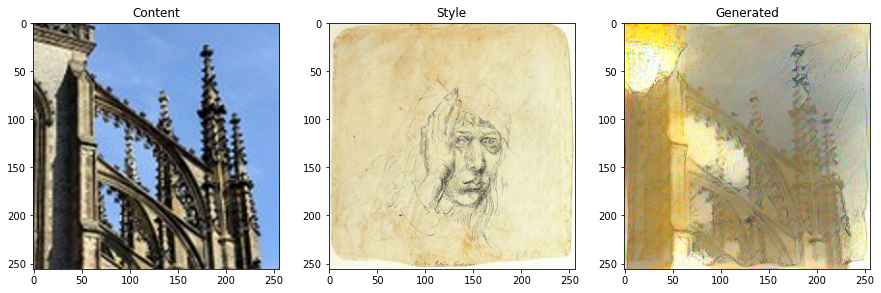

In [24]:
styler.generate_stylized_image(content_path="data/content/Train/5053497552_57b1880343_m.jpg",style_path="data/style/artist/Albrecht_DuΓòá├¬rer_314.jpg", output_dir="data/content/Train/5053497552_57b1880343_m",
                         content_wt=1.0, style_wt=100.0, image_size=(256,256))

Num Steps: 40 	Content Loss: 3.363 	Style Loss: 0.013 	Total Loss:4.625
Num Steps: 80 	Content Loss: 2.944 	Style Loss: 0.007 	Total Loss:3.646
Num Steps: 120 	Content Loss: 2.759 	Style Loss: 0.005 	Total Loss:3.294
Num Steps: 160 	Content Loss: 2.658 	Style Loss: 0.005 	Total Loss:3.119
Num Steps: 200 	Content Loss: 2.598 	Style Loss: 0.004 	Total Loss:3.02
Num Steps: 240 	Content Loss: 2.558 	Style Loss: 0.004 	Total Loss:2.957
Num Steps: 280 	Content Loss: 2.529 	Style Loss: 0.004 	Total Loss:2.912
Num Steps: 320 	Content Loss: 2.508 	Style Loss: 0.004 	Total Loss:2.876
Num Steps: 360 	Content Loss: 2.491 	Style Loss: 0.004 	Total Loss:2.848
Num Steps: 400 	Content Loss: 2.479 	Style Loss: 0.003 	Total Loss:2.825


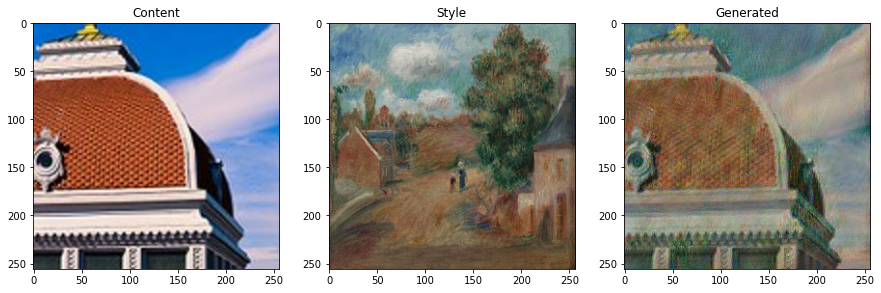

In [25]:
styler.generate_stylized_image(content_path="data/content/Train/6110196472_8e82745741_m.jpg",style_path="data/style/artist/Pierre-Auguste_Renoir_265.jpg", output_dir="data/content/Train/6110196472_8e82745741_m",
                         content_wt=1.0, style_wt=100.0, image_size=(256,256))